In [1]:
import os
import cv2
from sklearn.utils import shuffle 
import seaborn as sn; sn.set(font_scale=1.2)
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

In [2]:
class_names = ['Benign cases','Malignant cases', 'Normal cases']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [3]:
def load_data():
  
    datasets = ['train', 'test']
    output = []    
    for dataset in datasets:        
        images = []
        labels = []        
        print("Loading {}".format(dataset))
        
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):                
                img_path = os.path.join(os.path.join(dataset, folder), file)                
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE)                 
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
        
    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train


100%|███████████████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 428.39it/s]


Loading test


100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 428.57it/s]


In [5]:
from sklearn.utils import shuffle 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 876
Number of testing examples: 221
Each image is of size: (224, 224)


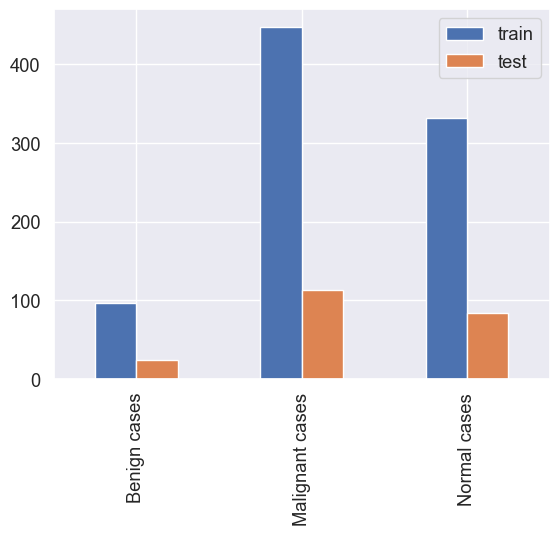

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
              'test': test_counts}, 
             index=class_names).plot.bar()

plt.show()

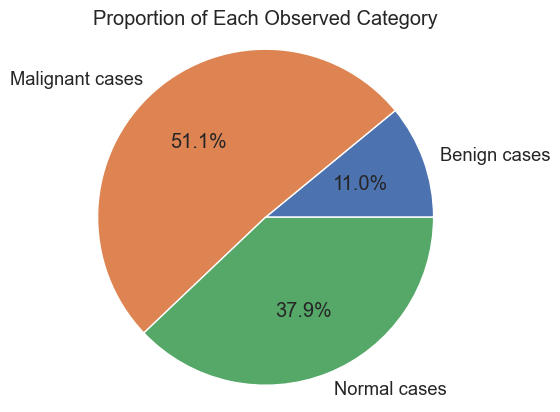

In [8]:
plt.pie(train_counts,
        explode=None, 
        labels=class_names,
        autopct='%1.1f%%')

plt.axis('equal')
plt.title('Proportion of Each Observed Category')
plt.show()

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [10]:
EPOCHS = 30
BATCH_SIZE = 64

In [11]:
from tensorflow.keras.utils import to_categorical

num_classes = 3
train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)

# CNN Architecture

In [12]:
import tensorflow as tf 
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [14]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"CNN.h5",verbose = 1,save_best_only = True,mode = 'auto')
cd_1 = [es,mc]

history = model.fit(train_images, train_labels_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split = 0.2,callbacks=cd_1)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 4.6054 - accuracy: 0.4700
Epoch 1: val_accuracy improved from -inf to 0.55682, saving model to CNN.h5
11/11 [==============================] - 4s 144ms/step - loss: 4.6054 - accuracy: 0.4700 - val_loss: 0.9928 - val_accuracy: 0.5568
Epoch 2/30
10/11 [==========================>...] - ETA: 0s - loss: 0.7882 - accuracy: 0.6922
Epoch 2: val_accuracy improved from 0.55682 to 0.77273, saving model to CNN.h5
11/11 [==============================] - 1s 73ms/step - loss: 0.7798 - accuracy: 0.6971 - val_loss: 0.6773 - val_accuracy: 0.7727
Epoch 3/30
10/11 [==========================>...] - ETA: 0s - loss: 0.3916 - accuracy: 0.8828
Epoch 3: val_accuracy improved from 0.77273 to 0.92045, saving model to CNN.h5
11/11 [==============================] - 1s 74ms/step - loss: 0.3773 - accuracy: 0.8857 - val_loss: 0.2388 - val_accuracy: 0.9205
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9757

# VGG16 Architecture

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = Flatten()(base_model.output)
predictions = Dense(num_classes, activation='softmax')(x)

model_2 = Model(inputs=base_model.input, outputs=predictions)
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
model_2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"VGG16.h5",verbose = 1,save_best_only = True,mode = 'auto')
cd_2 = [es,mc]
history_2 = model_2.fit(train_images, train_labels_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=cd_2)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.7274 - accuracy: 0.4786
Epoch 1: val_accuracy improved from -inf to 0.57955, saving model to VGG16.h5
11/11 [==============================] - 29s 2s/step - loss: 1.7274 - accuracy: 0.4786 - val_loss: 1.0936 - val_accuracy: 0.5795
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.7046 - accuracy: 0.7243
Epoch 2: val_accuracy improved from 0.57955 to 0.72159, saving model to VGG16.h5
11/11 [==============================] - 4s 382ms/step - loss: 0.7046 - accuracy: 0.7243 - val_loss: 0.5636 - val_accuracy: 0.7216
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8543
Epoch 3: val_accuracy did not improve from 0.72159
11/11 [==============================] - 4s 374ms/step - loss: 0.4604 - accuracy: 0.8543 - val_loss: 0.5369 - val_accuracy: 0.6989
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.8843
Epoch 4: val_accuracy i

7/7 [==============================] - 14s 1s/step - loss: 0.0612 - accuracy: 0.9774
VGG16 Architecture Accuracy on Test Data: 97.74%
7/7 [==============================] - 2s 373ms/step
Classification report for VGG16 Architecture: 
               precision    recall  f1-score   support

           0       1.00      0.79      0.88        24
           1       1.00      1.00      1.00       113
           2       0.94      1.00      0.97        84

    accuracy                           0.98       221
   macro avg       0.98      0.93      0.95       221
weighted avg       0.98      0.98      0.98       221

Confusion Matrix for model_2: 


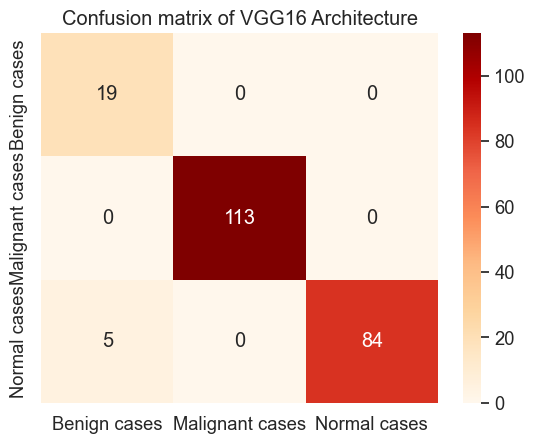

Precision Score for VGG16 Architecture:  0.978646601250699
Recall Score for VGG16 Architecture:  0.9773755656108597
F1 Score for VGG16 Architecture:  0.9763871342119526


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate VGG16 Architecture on test data
model_2_test_loss, model_2_test_acc = model_2.evaluate(test_images, to_categorical(test_labels, num_classes))
print("VGG16 Architecture Accuracy on Test Data: {:.2f}%".format(model_2_test_acc * 100))

model_2_preds = model_2.predict(test_images)
model_2_pred_labels = np.argmax(model_2_preds, axis=1)

# Metrics for VGG16 Architecture
print('\033[1m' + 'Classification report for VGG16 Architecture: ' + '\033[0m\n', classification_report(test_labels, model_2_pred_labels))

ax = plt.axes()
cm = confusion_matrix(model_2_pred_labels, test_labels)
print('\033[1m' + 'Confusion Matrix for model_2: ' + '\033[0m')
sn.heatmap(cm, cmap='OrRd', annot=True, fmt='d',
           xticklabels=class_names,
           yticklabels=class_names, ax=ax)
ax.set_title('Confusion matrix of VGG16 Architecture')
plt.show()

print("Precision Score for VGG16 Architecture: ", precision_score(test_labels, model_2_pred_labels, average='weighted'))
print("Recall Score for VGG16 Architecture: ", recall_score(test_labels, model_2_pred_labels, average='weighted'))
print("F1 Score for VGG16 Architecture: ", f1_score(test_labels, model_2_pred_labels, average='weighted'))

# Stacked Ensemble Model

In [19]:
import random
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, concatenate

In [20]:
model_cnn = tf.keras.models.load_model('CNN.h5')  
model_vgg16 = tf.keras.models.load_model('VGG16.h5')
preds_cnn_train = model_cnn.predict(train_images)
preds_vgg16_train = model_vgg16.predict(train_images)
preds_cnn_test = model_cnn.predict(test_images)
preds_vgg16_test = model_vgg16.predict(test_images)
stacked_model = Sequential([
    Dense(32, activation='relu', input_shape=(num_classes * 2,)),
    Dense(num_classes, activation='softmax')
])
concatenated_train_preds = np.concatenate([preds_cnn_train, preds_vgg16_train], axis=1)
concatenated_test_preds = np.concatenate([preds_cnn_test, preds_vgg16_test], axis=1)

7/7 [==============================] - 4s 738ms/step


In [21]:
es = EarlyStopping(monitor = "val_accuracy",min_delta = 0.01,patience = 10,verbose = 1,mode = 'auto')
mc = ModelCheckpoint(monitor = "val_accuracy",filepath =r"Stacked_Model.h5",verbose = 1,save_best_only = True,mode = 'auto')
cd_3 = [es,mc]
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
stacked_model.fit(concatenated_train_preds, train_labels_one_hot, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=cd_3)

Epoch 1/30
 1/11 [=>............................] - ETA: 2s - loss: 1.0391 - accuracy: 0.6562
Epoch 1: val_accuracy improved from -inf to 0.61932, saving model to Stacked_Model.h5
11/11 [==============================] - 0s 13ms/step - loss: 0.9965 - accuracy: 0.6200 - val_loss: 0.9367 - val_accuracy: 0.6193
Epoch 2/30
 1/11 [=>............................] - ETA: 0s - loss: 0.9328 - accuracy: 0.6094
Epoch 2: val_accuracy did not improve from 0.61932
11/11 [==============================] - 0s 4ms/step - loss: 0.8827 - accuracy: 0.6200 - val_loss: 0.8347 - val_accuracy: 0.6193
Epoch 3/30
 1/11 [=>............................] - ETA: 0s - loss: 0.8725 - accuracy: 0.5312
Epoch 3: val_accuracy improved from 0.61932 to 0.72727, saving model to Stacked_Model.h5
11/11 [==============================] - 0s 5ms/step - loss: 0.7845 - accuracy: 0.6357 - val_loss: 0.7462 - val_accuracy: 0.7273
Epoch 4/30
 1/11 [=>............................] - ETA: 0s - loss: 0.7234 - accuracy: 0.8438
Epoch 4: v

In [22]:
cnn_test_loss, cnn_test_acc = model.evaluate(test_images, to_categorical(test_labels, num_classes))
print("CNN Model Accuracy on Test Data: {:.2f}%".format(cnn_test_acc * 100))
vgg16_test_loss, vgg16_test_acc = model_2.evaluate(test_images, to_categorical(test_labels, num_classes))
print("VGG16 Model Accuracy on Test Data: {:.2f}%".format(vgg16_test_acc * 100))
concatenated_test_preds = np.concatenate([preds_cnn_test, preds_vgg16_test], axis=1)
stacked_test_loss, stacked_test_acc = stacked_model.evaluate(concatenated_test_preds, to_categorical(test_labels, num_classes))
print("Stacked Ensemble Model Accuracy on Test Data: {:.2f}%".format(stacked_test_acc * 100))


7/7 [==============================] - 0s 29ms/step - loss: 0.0319 - accuracy: 0.9864
CNN Model Accuracy on Test Data: 98.64%
7/7 [==============================] - 5s 736ms/step - loss: 0.0612 - accuracy: 0.9774
VGG16 Model Accuracy on Test Data: 97.74%
7/7 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9955
Stacked Ensemble Model Accuracy on Test Data: 99.55%


In [23]:
stacked_test_loss, stacked_test_acc = stacked_model.evaluate(concatenated_test_preds, to_categorical(test_labels, num_classes))
print("Stacked Ensemble Model Accuracy on Test Data: {:.2f}%".format(stacked_test_acc * 100))

7/7 [==============================] - 0s 2ms/step - loss: 0.1000 - accuracy: 0.9955
Stacked Ensemble Model Accuracy on Test Data: 99.55%


In [24]:
stacked_preds = stacked_model.predict(concatenated_test_preds)
stacked_pred_labels = np.argmax(stacked_preds, axis=1)

class_names = ['Benign cases', 'Malignant cases', 'Normal cases']
print('\033[1m' + 'Classification report : ' + '\033[0m\n', classification_report(test_labels, stacked_pred_labels))

7/7 [==============================] - 0s 2ms/step
Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       1.00      1.00      1.00       113
           2       0.99      1.00      0.99        84

    accuracy                           1.00       221
   macro avg       1.00      0.99      0.99       221
weighted avg       1.00      1.00      1.00       221



Confusion Matrix : 


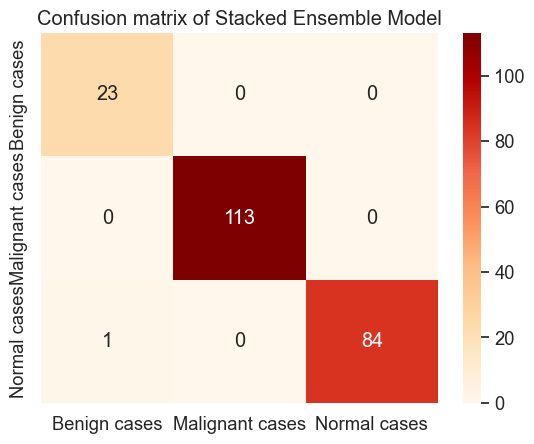

In [25]:
ax = plt.axes()
cm = confusion_matrix(stacked_pred_labels, test_labels)
print('\033[1m' + 'Confusion Matrix : ' + '\033[0m')
sn.heatmap(cm, cmap='OrRd', annot=True, fmt='d',
           xticklabels=class_names,
           yticklabels=class_names, ax=ax)
ax.set_title('Confusion matrix of Stacked Ensemble Model')
plt.show()

In [26]:
print("Precision Score : ", precision_score(test_labels, stacked_pred_labels, average='weighted'))
print("Recall Score : ", recall_score(test_labels, stacked_pred_labels, average='weighted'))
print("F1 Score : ", f1_score(test_labels, stacked_pred_labels, average='weighted'))

Precision Score :  0.9955283470854405
Recall Score :  0.995475113122172
F1 Score :  0.9954403632670105
